# Import Repo of Sepsis Simulator

In [ ]:
!git clone https://github.com/clinicalml/gumbel-max-scm.git

Cloning into 'gumbel-max-scm'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 1.48 MiB | 16.61 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
#Enable importing code from parent directory
import os, sys
simulator_path = os.path.abspath('./gumbel-max-scm')
sys.path.insert(1, simulator_path)

In [ ]:
!pip install pymdptoolbox

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25657 sha256=c1677c61c9601cbed1278eb0603e2784075d9be2becc6a6e3a6677c46dbed800
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox


In [ ]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up Variables and Functions

Code taken from [Oberst and Sontag](https://github.com/clinicalml/gumbel-max-scm/blob/master/plots-main-paper.ipynb).

Set up important variables

In [ ]:
SEED = 1
np.random.seed(SEED)
NSIMSAMPS = 100000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 5  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

# Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
USE_BOOSTRAP=True
N_BOOTSTRAP = 100

# Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars;
# This is done in the appendix of the paper, but not in the main paper
N_REPEAT_SAMPLING = 1

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
n_states_abs = State.NUM_OBS_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

In [ ]:
hr_state_mapping = ['Low', 'Normal', 'High']
sbp_state_mapping = ['Low', 'Normal', 'High']
o2_state_mapping = ['Low', 'Normal']
glu_state_mapping = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
abx_state_mapping = ['Off', 'On']
vaso_state_mapping = ['Off', 'On']
vent_state_mapping = ['Off', 'On']
diab_state_mapping = ['No', 'Yes']

Set up base for behaviour and evaluation policies

In [ ]:
import zipfile
with zipfile.ZipFile("gumbel-max-scm/data/diab_txr_mats-replication.zip", 'r') as zip_ref:
    zip_ref.extractall("gumbel-max-scm/data")

In [ ]:
# Get the transition and reward matrix from file
with open("gumbel-max-scm/data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]

In [ ]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [ ]:
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

fullPolmaxes = np.argmax(fullPol, axis=-1)

Functions to convert data and policies into factored format

In [ ]:
def factorise_dataset(data):
  #With two action spaces: (ABX, VASO) and (VENT), we can perfectly satisfy theorem 1
  f_transitions_anva_ve = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  #We also investigate the factorisations that would not satisfy theorem 1:
  # (ABX, VENT), (VASO)
  f_transitions_anve_va = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  # (VENT, VASO), (ABX)
  f_transitions_veva_an = np.zeros((NSIMSAMPS, NSTEPS, 2, 5))
  #With three action spaces, we can reduce the variance but may increase bias
  f_transitions_an_va_ve = np.zeros((NSIMSAMPS, NSTEPS, 3, 5))

  #Transform unfactored data sample by sample
  for step in range(NSTEPS):
    for trajectory in range(NSIMSAMPS):
      #Extract necessary features
      seg = data[trajectory, step, :]
      time = seg[0]
      state = seg[1]
      action = seg[2]
      reward = seg[3]
      next_state = seg[4]

      #Set times
      f_transitions_anva_ve[trajectory, step, :, 0] = [time]*2
      f_transitions_anve_va[trajectory, step, :, 0] = [time]*2
      f_transitions_veva_an[trajectory, step, :, 0] = [time]*2
      f_transitions_an_va_ve[trajectory, step, :, 0] = [time]*3

      #Set factored states (state abstractions)
      f_transitions_anva_ve[trajectory, step, :, 1] = [state]*2
      f_transitions_anve_va[trajectory, step, :, 1] = [state]*2
      f_transitions_veva_an[trajectory, step, :, 1] = [state]*2
      f_transitions_an_va_ve[trajectory, step, :, 1] = [state]*3

      #Set factored actions
      actionObj = Action(action_idx=action)
      action_vec = actionObj.get_action_vec()

      f_transitions_anva_ve[trajectory, step, 0, 2] = action_vec[1,0]
      f_transitions_anva_ve[trajectory, step, 1, 2] = 2*action_vec[0,0] + action_vec[2,0]

      f_transitions_anve_va[trajectory, step, 0, 2] = action_vec[2,0]
      f_transitions_anve_va[trajectory, step, 1, 2] = 2*action_vec[0,0] + action_vec[1,0]

      f_transitions_veva_an[trajectory, step, 0, 2] = action_vec[0,0]
      f_transitions_veva_an[trajectory, step, 1, 2] = 2*action_vec[1,0] + action_vec[2,0]

      f_transitions_an_va_ve[trajectory, step, 0, 2] = action_vec[0,0]
      f_transitions_an_va_ve[trajectory, step, 1, 2] = action_vec[1,0]
      f_transitions_an_va_ve[trajectory, step, 2, 2] = action_vec[2,0]

      #Set factored rewards
      f_transitions_anva_ve[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_anve_va[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_veva_an[trajectory, step, :, 3] = [reward/2.0]*2
      f_transitions_an_va_ve[trajectory, step, :, 3] = [reward/3.0]*3

      #Set factored next states (state abstractions)
      f_transitions_anva_ve[trajectory, step, :, 4] = [next_state]*2
      f_transitions_anve_va[trajectory, step, :, 4] = [next_state]*2
      f_transitions_veva_an[trajectory, step, :, 4] = [next_state]*2
      f_transitions_an_va_ve[trajectory, step, :, 4] = [next_state]*3

  return f_transitions_anva_ve,  f_transitions_anve_va, f_transitions_veva_an, f_transitions_an_va_ve

In [ ]:
def bin_to_num(bitlist):
  out = 0
  for bit in bitlist:
    out = (out << 1) | bit
  return out

#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_1(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], 0, index_pair[1]])] + policy[ind, bin_to_num([index_pair[0], 1, index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([max_pair[0], 0, max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([max_pair[0], 1, max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([0, index, 0])] + policy[ind, bin_to_num([0, index, 1])] + policy[ind, bin_to_num([1, index, 0])] + + policy[ind, bin_to_num([1, index, 1])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([0, max_id, 0])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([0, max_id, 1])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([1, max_id, 0])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([1, max_id, 1])]/max_sum

  reconstruction_error = np.zeros(policy.shape)
  for ind in range(policy.shape[0]):
    for index in [[x,y,z] for x in [0,1] for y in [0,1] for z in [0,1]]:
      action_id = bin_to_num(index)
      true = policy[ind, action_id]
      reconstruct = factored_policy_1[ind, index[0]]*factored_policy_2[ind, bin_to_num(index[1:])]
      reconstruction_error[ind, action_id] = abs(true - reconstruct)

  return [factored_policy_1, factored_policy_2], reconstruction_error

In [ ]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_2(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], index_pair[1], 0])] + policy[ind, bin_to_num([index_pair[0], index_pair[1], 1])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 0])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 1])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([0, 0, index])] + policy[ind, bin_to_num([0, 1, index])] + policy[ind, bin_to_num([1, 0, index])] + + policy[ind, bin_to_num([1, 1, index])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([0, 0, max_id])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([0, 1, max_id])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([1, 0, max_id])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([1, 1, max_id])]/max_sum

  reconstruction_error = np.zeros(policy.shape)
  for ind in range(policy.shape[0]):
    for index in [[x,y,z] for x in [0,1] for y in [0,1] for z in [0,1]]:
      action_id = bin_to_num(index)
      true = policy[ind, action_id]
      reconstruct = factored_policy_1[ind, index[0]]*factored_policy_2[ind, bin_to_num(index[1:])]
      reconstruction_error[ind, action_id] = abs(true - reconstruct)

  return [factored_policy_1, factored_policy_2], reconstruction_error

In [ ]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_3(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([0, index_pair[0], index_pair[1]])] + policy[ind, bin_to_num([1, index_pair[0], index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([0, max_pair[0], max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([1, max_pair[0], max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 4))
  for ind in range(policy.shape[0]):
    max_id = None
    max_sum = 0.0
    for index in [0, 1]:
      new_sum = policy[ind, bin_to_num([index, 0, 0])] + policy[ind, bin_to_num([index, 0, 1])] + policy[ind, bin_to_num([index, 1, 0])] + + policy[ind, bin_to_num([index, 1, 1])]
      if new_sum > max_sum:
        max_id = index
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([max_id, 0, 0])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([max_id, 0, 1])]/max_sum
    factored_policy_2[ind, 2] = policy[ind, bin_to_num([max_id, 1, 0])]/max_sum
    factored_policy_2[ind, 3] = policy[ind, bin_to_num([max_id, 1, 1])]/max_sum

  reconstruction_error = np.zeros(policy.shape)
  for ind in range(policy.shape[0]):
    for index in [[x,y,z] for x in [0,1] for y in [0,1] for z in [0,1]]:
      action_id = bin_to_num(index)
      true = policy[ind, action_id]
      reconstruct = factored_policy_1[ind, index[0]]*factored_policy_2[ind, bin_to_num(index[1:])]
      reconstruction_error[ind, action_id] = abs(true - reconstruct)

  return [factored_policy_1, factored_policy_2], reconstruction_error

In [ ]:
#Number codes:
#1 = (ABX, VAS), (VENT)
#2 = (ABX, VENT), (VAS)
#3 = (VENT, VAS), (ABX)
#4 = (ABX), (VENT), (VAS)
def factor_policy_4(policy):

  factored_policy_1 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([0, index_pair[0], index_pair[1]])] + policy[ind, bin_to_num([1, index_pair[0], index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_1[ind, 0] = policy[ind, bin_to_num([0, max_pair[0], max_pair[1]])]/max_sum
    factored_policy_1[ind, 1] = policy[ind, bin_to_num([1, max_pair[0], max_pair[1]])]/max_sum

  factored_policy_2 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], 0, index_pair[1]])] + policy[ind, bin_to_num([index_pair[0], 1, index_pair[1]])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_2[ind, 0] = policy[ind, bin_to_num([max_pair[0], 0, max_pair[1]])]/max_sum
    factored_policy_2[ind, 1] = policy[ind, bin_to_num([max_pair[0], 1, max_pair[1]])]/max_sum

  factored_policy_3 = np.zeros((policy.shape[0], 2))
  for ind in range(policy.shape[0]):
    max_pair = None
    max_sum = 0.0
    for index_pair in [(0,0), (0,1), (1,0), (1,1)]:
      new_sum = policy[ind, bin_to_num([index_pair[0], index_pair[1], 0])] + policy[ind, bin_to_num([index_pair[0], index_pair[1], 1])]
      if new_sum > max_sum:
        max_pair = index_pair
        max_sum = new_sum
    factored_policy_3[ind, 0] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 0])]/max_sum
    factored_policy_3[ind, 1] = policy[ind, bin_to_num([max_pair[0], max_pair[1], 1])]/max_sum

  reconstruction_error = np.zeros(policy.shape)
  for ind in range(policy.shape[0]):
    for index in [[x,y,z] for x in [0,1] for y in [0,1] for z in [0,1]]:
      action_id = bin_to_num(index)
      true = policy[ind, action_id]
      reconstruct = factored_policy_1[ind, index[0]]*factored_policy_2[ind, index[1]]*factored_policy_3[ind, index[2]]
      reconstruction_error[ind, action_id] = abs(true - reconstruct)

  return [factored_policy_1, factored_policy_2, factored_policy_3], reconstruction_error

# $\epsilon_{e} = 0.1$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.1

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[1.40489719e-02, 6.29058442e-04, 1.40489719e-02, ...,
        9.25344968e-01, 6.29058442e-04, 6.29058442e-04],
       [1.40489719e-02, 6.29058442e-04, 1.40489719e-02, ...,
        9.25344968e-01, 6.29058442e-04, 6.29058442e-04],
       [1.40489719e-02, 6.29058442e-04, 1.40489719e-02, ...,
        9.25344968e-01, 6.29058442e-04, 6.29058442e-04],
       ...,
       [1.40489719e-02, 1.40489719e-02, 6.29058442e-04, ...,
        6.29058442e-04, 3.96306818e-02, 6.29058442e-04],
       [1.40489719e-02, 1.40489719e-02, 6.29058442e-04, ...,
        6.29058442e-04, 3.96306818e-02, 6.29058442e-04],
       [1.40489719e-02, 1.40489719e-02, 6.29058442e-04, ...,
        6.29058442e-04, 3.96306818e-02, 6.29058442e-04]])

In [ ]:
error2

array([[1.40489719e-02, 6.29058442e-04, 1.40489719e-02, ...,
        9.25344968e-01, 6.29058442e-04, 6.29058442e-04],
       [1.40489719e-02, 6.29058442e-04, 1.40489719e-02, ...,
        9.25344968e-01, 6.29058442e-04, 6.29058442e-04],
       [1.40489719e-02, 6.29058442e-04, 1.40489719e-02, ...,
        9.25344968e-01, 6.29058442e-04, 6.29058442e-04],
       ...,
       [6.29058442e-04, 6.29058442e-04, 6.29058442e-04, ...,
        1.40489719e-02, 8.99763258e-01, 6.29058442e-04],
       [6.29058442e-04, 6.29058442e-04, 6.29058442e-04, ...,
        1.40489719e-02, 8.99763258e-01, 6.29058442e-04],
       [6.29058442e-04, 6.29058442e-04, 6.29058442e-04, ...,
        1.40489719e-02, 8.99763258e-01, 6.29058442e-04]])

In [ ]:
error3

array([[0.00062906, 0.00062906, 0.00062906, ..., 0.01404897, 0.01404897,
        0.00062906],
       [0.00062906, 0.00062906, 0.00062906, ..., 0.01404897, 0.01404897,
        0.00062906],
       [0.00062906, 0.00062906, 0.00062906, ..., 0.01404897, 0.01404897,
        0.00062906],
       ...,
       [0.01404897, 0.01404897, 0.00062906, ..., 0.00062906, 0.03963068,
        0.00062906],
       [0.01404897, 0.01404897, 0.00062906, ..., 0.00062906, 0.03963068,
        0.00062906],
       [0.01404897, 0.01404897, 0.00062906, ..., 0.00062906, 0.03963068,
        0.00062906]])

In [ ]:
error4

array([[0.01404539, 0.00085482, 0.00085482, ..., 0.01404539, 0.01404539,
        0.00085482],
       [0.01404539, 0.00085482, 0.00085482, ..., 0.01404539, 0.01404539,
        0.00085482],
       [0.01404539, 0.00085482, 0.00085482, ..., 0.01404539, 0.01404539,
        0.00085482],
       ...,
       [0.01404539, 0.0142819 , 0.00085482, ..., 0.01404539, 0.05385361,
        0.00085482],
       [0.01404539, 0.0142819 , 0.00085482, ..., 0.01404539, 0.05385361,
        0.00085482],
       [0.01404539, 0.0142819 , 0.00085482, ..., 0.01404539, 0.05385361,
        0.00085482]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.96875
0.3854166666666667
0.7895833333333333
0.9048611111111111


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.057590300324675346---0.1726000941332973---0.010536728896103902---0.014104516165597096


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.9253449675324678---0.9253449675324678---0.03963068181818197---0.05385360717773435


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.0006290584415584444---0.0006290584415584444---0.0006290584415584426---0.0008548191615513415


# $\epsilon_{e} = 0.2$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.2

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.02745908, 0.00257429, 0.02745908, ..., 0.84350866, 0.00257429,
        0.00257429],
       [0.02745908, 0.00257429, 0.02745908, ..., 0.84350866, 0.00257429,
        0.00257429],
       [0.02745908, 0.00257429, 0.02745908, ..., 0.84350866, 0.00257429,
        0.00257429],
       ...,
       [0.02745908, 0.02745908, 0.00257429, ..., 0.00257429, 0.07208009,
        0.00257429],
       [0.02745908, 0.02745908, 0.00257429, ..., 0.00257429, 0.07208009,
        0.00257429],
       [0.02745908, 0.02745908, 0.00257429, ..., 0.00257429, 0.07208009,
        0.00257429]])

In [ ]:
error2

array([[0.02745908, 0.00257429, 0.02745908, ..., 0.84350866, 0.00257429,
        0.00257429],
       [0.02745908, 0.00257429, 0.02745908, ..., 0.84350866, 0.00257429,
        0.00257429],
       [0.02745908, 0.00257429, 0.02745908, ..., 0.84350866, 0.00257429,
        0.00257429],
       ...,
       [0.00257429, 0.00257429, 0.00257429, ..., 0.02745908, 0.79888765,
        0.00257429],
       [0.00257429, 0.00257429, 0.00257429, ..., 0.02745908, 0.79888765,
        0.00257429],
       [0.00257429, 0.00257429, 0.00257429, ..., 0.02745908, 0.79888765,
        0.00257429]])

In [ ]:
error3

array([[0.00257429, 0.00257429, 0.00257429, ..., 0.02745908, 0.02745908,
        0.00257429],
       [0.00257429, 0.00257429, 0.00257429, ..., 0.02745908, 0.02745908,
        0.00257429],
       [0.00257429, 0.00257429, 0.00257429, ..., 0.02745908, 0.02745908,
        0.00257429],
       ...,
       [0.02745908, 0.02745908, 0.00257429, ..., 0.00257429, 0.07208009,
        0.00257429],
       [0.02745908, 0.02745908, 0.00257429, ..., 0.00257429, 0.07208009,
        0.00257429],
       [0.02745908, 0.02745908, 0.00257429, ..., 0.00257429, 0.07208009,
        0.00257429]])

In [ ]:
error4

array([[0.02742337, 0.00357421, 0.00357421, ..., 0.02742337, 0.02742337,
        0.00357421],
       [0.02742337, 0.00357421, 0.00357421, ..., 0.02742337, 0.02742337,
        0.00357421],
       [0.02742337, 0.00357421, 0.00357421, ..., 0.02742337, 0.02742337,
        0.00357421],
       ...,
       [0.02742337, 0.02853043, 0.00357421, ..., 0.02742337, 0.1000779 ,
        0.00357421],
       [0.02742337, 0.02853043, 0.00357421, ..., 0.02742337, 0.1000779 ,
        0.00357421],
       [0.02742337, 0.02853043, 0.00357421, ..., 0.02742337, 0.1000779 ,
        0.00357421]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9048611111111111
0.3854166666666667
0.7729166666666667
0.9048611111111111


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.06157645399650404---0.16171390831082152---0.0205943111393612---0.027700134135412356


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.8435086604163357---0.8435086604163357---0.07208008898776419---0.10007790397310279


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.0025742888924201457---0.0025742888924201457---0.0025742888924201457---0.0035742108561822375


# $\epsilon_{e} = 0.3$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.3

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.03987306, 0.00588291, 0.03987306, ..., 0.75323039, 0.00588291,
        0.00588291],
       [0.03987306, 0.00588291, 0.03987306, ..., 0.75323039, 0.00588291,
        0.00588291],
       [0.03987306, 0.00588291, 0.03987306, ..., 0.75323039, 0.00588291,
        0.00588291],
       ...,
       [0.03987306, 0.03987306, 0.00588291, ..., 0.00588291, 0.09608753,
        0.00588291],
       [0.03987306, 0.03987306, 0.00588291, ..., 0.00588291, 0.09608753,
        0.00588291],
       [0.03987306, 0.03987306, 0.00588291, ..., 0.00588291, 0.09608753,
        0.00588291]])

In [ ]:
error2

array([[0.03987306, 0.00588291, 0.03987306, ..., 0.75323039, 0.00588291,
        0.00588291],
       [0.03987306, 0.00588291, 0.03987306, ..., 0.75323039, 0.00588291,
        0.00588291],
       [0.03987306, 0.00588291, 0.03987306, ..., 0.75323039, 0.00588291,
        0.00588291],
       ...,
       [0.00588291, 0.00588291, 0.00588291, ..., 0.03987306, 0.69701592,
        0.00588291],
       [0.00588291, 0.00588291, 0.00588291, ..., 0.03987306, 0.69701592,
        0.00588291],
       [0.00588291, 0.00588291, 0.00588291, ..., 0.03987306, 0.69701592,
        0.00588291]])

In [ ]:
error3

array([[0.00588291, 0.00588291, 0.00588291, ..., 0.03987306, 0.03987306,
        0.00588291],
       [0.00588291, 0.00588291, 0.00588291, ..., 0.03987306, 0.03987306,
        0.00588291],
       [0.00588291, 0.00588291, 0.00588291, ..., 0.03987306, 0.03987306,
        0.00588291],
       ...,
       [0.03987306, 0.03987306, 0.00588291, ..., 0.00588291, 0.09608753,
        0.00588291],
       [0.03987306, 0.03987306, 0.00588291, ..., 0.00588291, 0.09608753,
        0.00588291],
       [0.03987306, 0.03987306, 0.00588291, ..., 0.00588291, 0.09608753,
        0.00588291]])

In [ ]:
error4

array([[0.03972076, 0.00837038, 0.00837038, ..., 0.03972076, 0.03972076,
        0.00837038],
       [0.03972076, 0.00837038, 0.00837038, ..., 0.03972076, 0.03972076,
        0.00837038],
       [0.03972076, 0.00837038, 0.00837038, ..., 0.03972076, 0.03972076,
        0.00837038],
       ...,
       [0.03972076, 0.04266512, 0.00837038, ..., 0.03972076, 0.13671626,
        0.00837038],
       [0.03972076, 0.04266512, 0.00837038, ..., 0.03972076, 0.13671626,
        0.00837038],
       [0.03972076, 0.04266512, 0.00837038, ..., 0.03972076, 0.13671626,
        0.00837038]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9048611111111111
0.3854166666666667
0.7729166666666667
0.9048611111111111


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.06481550776809401---0.15005884620647553---0.02990479348237972---0.040456852688731434


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.753230390299356---0.753230390299356---0.09608753315649887---0.13671626081019606


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.005882910193255035---0.005882910193255035---0.005882910193255028---0.008370383314909961


# $\epsilon_{e} = 0.4$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.05070163, 0.01048999, 0.05070163, ..., 0.65300207, 0.01048999,
        0.01048999],
       [0.05070163, 0.01048999, 0.05070163, ..., 0.65300207, 0.01048999,
        0.01048999],
       [0.05070163, 0.01048999, 0.05070163, ..., 0.65300207, 0.01048999,
        0.01048999],
       ...,
       [0.05070163, 0.05070163, 0.01048999, ..., 0.01048999, 0.11014493,
        0.01048999],
       [0.05070163, 0.05070163, 0.01048999, ..., 0.01048999, 0.11014493,
        0.01048999],
       [0.05070163, 0.05070163, 0.01048999, ..., 0.01048999, 0.11014493,
        0.01048999]])

In [ ]:
error2

array([[0.05070163, 0.01048999, 0.05070163, ..., 0.65300207, 0.01048999,
        0.01048999],
       [0.05070163, 0.01048999, 0.05070163, ..., 0.65300207, 0.01048999,
        0.01048999],
       [0.05070163, 0.01048999, 0.05070163, ..., 0.65300207, 0.01048999,
        0.01048999],
       ...,
       [0.01048999, 0.01048999, 0.01048999, ..., 0.05070163, 0.59355878,
        0.01048999],
       [0.01048999, 0.01048999, 0.01048999, ..., 0.05070163, 0.59355878,
        0.01048999],
       [0.01048999, 0.01048999, 0.01048999, ..., 0.05070163, 0.59355878,
        0.01048999]])

In [ ]:
error3

array([[0.01048999, 0.01048999, 0.01048999, ..., 0.05070163, 0.05070163,
        0.01048999],
       [0.01048999, 0.01048999, 0.01048999, ..., 0.05070163, 0.05070163,
        0.01048999],
       [0.01048999, 0.01048999, 0.01048999, ..., 0.05070163, 0.05070163,
        0.01048999],
       ...,
       [0.05070163, 0.05070163, 0.01048999, ..., 0.01048999, 0.11014493,
        0.01048999],
       [0.05070163, 0.05070163, 0.01048999, ..., 0.01048999, 0.11014493,
        0.01048999],
       [0.05070163, 0.05070163, 0.01048999, ..., 0.01048999, 0.11014493,
        0.01048999]])

In [ ]:
error4

array([[0.05023894, 0.01534831, 0.01534831, ..., 0.05023894, 0.05023894,
        0.01534831],
       [0.05023894, 0.01534831, 0.01534831, ..., 0.05023894, 0.05023894,
        0.01534831],
       [0.05023894, 0.01534831, 0.01534831, ..., 0.05023894, 0.05023894,
        0.01534831],
       ...,
       [0.05023894, 0.05648534, 0.01534831, ..., 0.05023894, 0.16115723,
        0.01534831],
       [0.05023894, 0.05648534, 0.01534831, ..., 0.05023894, 0.16115723,
        0.01534831],
       [0.05023894, 0.05648534, 0.01534831, ..., 0.05023894, 0.16115723,
        0.01534831]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9361111111111111
0.48055555555555557
0.8513888888888889
0.9854166666666667


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.06686551069703242---0.13719399394218232---0.03802622498274671---0.05180053775434722


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.6530020703933745---0.6530020703933747---0.11014492753623184---0.1611572285690801


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.01048999309868874---0.01048999309868874---0.010489993098688755---0.015348307482769538


# $\epsilon_{e} = 0.5$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.5

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.05892857, 0.01607143, 0.05892857, ..., 0.54107143, 0.01607143,
        0.01607143],
       [0.05892857, 0.01607143, 0.05892857, ..., 0.54107143, 0.01607143,
        0.01607143],
       [0.05892857, 0.01607143, 0.05892857, ..., 0.54107143, 0.01607143,
        0.01607143],
       ...,
       [0.05892857, 0.05892857, 0.01607143, ..., 0.01607143, 0.1125    ,
        0.01607143],
       [0.05892857, 0.05892857, 0.01607143, ..., 0.01607143, 0.1125    ,
        0.01607143],
       [0.05892857, 0.05892857, 0.01607143, ..., 0.01607143, 0.1125    ,
        0.01607143]])

In [ ]:
error2

array([[0.05892857, 0.01607143, 0.05892857, ..., 0.54107143, 0.01607143,
        0.01607143],
       [0.05892857, 0.01607143, 0.05892857, ..., 0.54107143, 0.01607143,
        0.01607143],
       [0.05892857, 0.01607143, 0.05892857, ..., 0.54107143, 0.01607143,
        0.01607143],
       ...,
       [0.01607143, 0.01607143, 0.01607143, ..., 0.05892857, 0.4875    ,
        0.01607143],
       [0.01607143, 0.01607143, 0.01607143, ..., 0.05892857, 0.4875    ,
        0.01607143],
       [0.01607143, 0.01607143, 0.01607143, ..., 0.05892857, 0.4875    ,
        0.01607143]])

In [ ]:
error3

array([[0.01607143, 0.01607143, 0.01607143, ..., 0.05892857, 0.05892857,
        0.01607143],
       [0.01607143, 0.01607143, 0.01607143, ..., 0.05892857, 0.05892857,
        0.01607143],
       [0.01607143, 0.01607143, 0.01607143, ..., 0.05892857, 0.05892857,
        0.01607143],
       ...,
       [0.05892857, 0.05892857, 0.01607143, ..., 0.01607143, 0.1125    ,
        0.01607143],
       [0.05892857, 0.05892857, 0.01607143, ..., 0.01607143, 0.1125    ,
        0.01607143],
       [0.05892857, 0.05892857, 0.01607143, ..., 0.01607143, 0.1125    ,
        0.01607143]])

In [ ]:
error4

array([[0.0577567 , 0.02427455, 0.02427455, ..., 0.0577567 , 0.0577567 ,
        0.02427455],
       [0.0577567 , 0.02427455, 0.02427455, ..., 0.0577567 , 0.0577567 ,
        0.02427455],
       [0.0577567 , 0.02427455, 0.02427455, ..., 0.0577567 , 0.0577567 ,
        0.02427455],
       ...,
       [0.0577567 , 0.06947545, 0.02427455, ..., 0.0577567 , 0.16992188,
        0.02427455],
       [0.0577567 , 0.06947545, 0.02427455, ..., 0.0577567 , 0.16992188,
        0.02427455],
       [0.0577567 , 0.06947545, 0.02427455, ..., 0.0577567 , 0.16992188,
        0.02427455]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9048611111111111
0.3854166666666667
0.7729166666666667
0.9048611111111111


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.06696428571428571---0.12236235119047618---0.04419642857142857---0.060686383928571425


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.5410714285714286---0.5410714285714286---0.11250000000000004---0.169921875


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.016071428571428584---0.016071428571428584---0.01607142857142857---0.024274553571428575


# $\epsilon_{e} = 0.6$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.6

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.06269638, 0.02170259, 0.06269638, ..., 0.41556449, 0.02170259,
        0.02170259],
       [0.06269638, 0.02170259, 0.06269638, ..., 0.41556449, 0.02170259,
        0.02170259],
       [0.06269638, 0.02170259, 0.06269638, ..., 0.41556449, 0.02170259,
        0.02170259],
       ...,
       [0.06269638, 0.06269638, 0.02170259, ..., 0.02170259, 0.10127877,
        0.02170259],
       [0.06269638, 0.06269638, 0.02170259, ..., 0.02170259, 0.10127877,
        0.02170259],
       [0.06269638, 0.06269638, 0.02170259, ..., 0.02170259, 0.10127877,
        0.02170259]])

In [ ]:
error2

array([[0.06269638, 0.02170259, 0.06269638, ..., 0.41556449, 0.02170259,
        0.02170259],
       [0.06269638, 0.02170259, 0.06269638, ..., 0.41556449, 0.02170259,
        0.02170259],
       [0.06269638, 0.02170259, 0.06269638, ..., 0.41556449, 0.02170259,
        0.02170259],
       ...,
       [0.02170259, 0.02170259, 0.02170259, ..., 0.06269638, 0.3769821 ,
        0.02170259],
       [0.02170259, 0.02170259, 0.02170259, ..., 0.06269638, 0.3769821 ,
        0.02170259],
       [0.02170259, 0.02170259, 0.02170259, ..., 0.06269638, 0.3769821 ,
        0.02170259]])

In [ ]:
error3

array([[0.02170259, 0.02170259, 0.02170259, ..., 0.06269638, 0.06269638,
        0.02170259],
       [0.02170259, 0.02170259, 0.02170259, ..., 0.06269638, 0.06269638,
        0.02170259],
       [0.02170259, 0.02170259, 0.02170259, ..., 0.06269638, 0.06269638,
        0.02170259],
       ...,
       [0.06269638, 0.06269638, 0.02170259, ..., 0.02170259, 0.10127877,
        0.02170259],
       [0.06269638, 0.06269638, 0.02170259, ..., 0.02170259, 0.10127877,
        0.02170259],
       [0.06269638, 0.06269638, 0.02170259, ..., 0.02170259, 0.10127877,
        0.02170259]])

In [ ]:
error4

array([[0.06006804, 0.03396819, 0.03396819, ..., 0.06006804, 0.06006804,
        0.03396819],
       [0.06006804, 0.03396819, 0.03396819, ..., 0.06006804, 0.06006804,
        0.03396819],
       [0.06006804, 0.03396819, 0.03396819, ..., 0.06006804, 0.06006804,
        0.03396819],
       ...,
       [0.06006804, 0.08021866, 0.03396819, ..., 0.06006804, 0.15851822,
        0.03396819],
       [0.06006804, 0.08021866, 0.03396819, ..., 0.06006804, 0.15851822,
        0.03396819],
       [0.06006804, 0.08021866, 0.03396819, ..., 0.06006804, 0.15851822,
        0.03396819]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9048611111111111
0.3854166666666667
0.7729166666666667
0.9194444444444444


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.06371871574716842---0.10418556915519829---0.04702228717573985---0.06510569625774185


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.41556448666423085---0.41556448666423085---0.10127877237851657---0.15851821697537138


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.02170259408111068---0.02170259408111068---0.021702594081110693---0.03396818935186528


# $\epsilon_{e} = 0.7$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.7

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.05833333, 0.025     , 0.05833333, ..., 0.275     , 0.025     ,
        0.025     ],
       [0.05833333, 0.025     , 0.05833333, ..., 0.275     , 0.025     ,
        0.025     ],
       [0.05833333, 0.025     , 0.05833333, ..., 0.275     , 0.025     ,
        0.025     ],
       ...,
       [0.05833333, 0.05833333, 0.025     , ..., 0.025     , 0.075     ,
        0.025     ],
       [0.05833333, 0.05833333, 0.025     , ..., 0.025     , 0.075     ,
        0.025     ],
       [0.05833333, 0.05833333, 0.025     , ..., 0.025     , 0.075     ,
        0.025     ]])

In [ ]:
error2

array([[0.05833333, 0.025     , 0.05833333, ..., 0.275     , 0.025     ,
        0.025     ],
       [0.05833333, 0.025     , 0.05833333, ..., 0.275     , 0.025     ,
        0.025     ],
       [0.05833333, 0.025     , 0.05833333, ..., 0.275     , 0.025     ,
        0.025     ],
       ...,
       [0.025     , 0.025     , 0.025     , ..., 0.05833333, 0.25833333,
        0.025     ],
       [0.025     , 0.025     , 0.025     , ..., 0.05833333, 0.25833333,
        0.025     ],
       [0.025     , 0.025     , 0.025     , ..., 0.05833333, 0.25833333,
        0.025     ]])

In [ ]:
error3

array([[0.025     , 0.025     , 0.025     , ..., 0.05833333, 0.05833333,
        0.025     ],
       [0.025     , 0.025     , 0.025     , ..., 0.05833333, 0.05833333,
        0.025     ],
       [0.025     , 0.025     , 0.025     , ..., 0.05833333, 0.05833333,
        0.025     ],
       ...,
       [0.05833333, 0.05833333, 0.025     , ..., 0.025     , 0.075     ,
        0.025     ],
       [0.05833333, 0.05833333, 0.025     , ..., 0.025     , 0.075     ,
        0.025     ],
       [0.05833333, 0.05833333, 0.025     , ..., 0.025     , 0.075     ,
        0.025     ]])

In [ ]:
error4

array([[0.053125, 0.040625, 0.040625, ..., 0.053125, 0.053125, 0.040625],
       [0.053125, 0.040625, 0.040625, ..., 0.053125, 0.053125, 0.040625],
       [0.053125, 0.040625, 0.040625, ..., 0.053125, 0.053125, 0.040625],
       ...,
       [0.053125, 0.084375, 0.040625, ..., 0.053125, 0.121875, 0.040625],
       [0.053125, 0.084375, 0.040625, ..., 0.053125, 0.121875, 0.040625],
       [0.053125, 0.084375, 0.040625, ..., 0.053125, 0.121875, 0.040625]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.2125
0.7319444444444444
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9048611111111111
0.3854166666666667
0.7729166666666667
0.9048611111111111


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.05437500000000003---0.07994791666666669---0.04375000000000002---0.060937500000000026


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.2750000000000002---0.2750000000000002---0.07500000000000012---0.12187500000000018


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.02500000000000001---0.02500000000000001---0.024999999999999994---0.040625000000000036


# $\epsilon_{e} = 0.8$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.8

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.03773069, 0.01968558, 0.03773069, ..., 0.12016405, 0.01968558,
        0.01968558],
       [0.03773069, 0.01968558, 0.03773069, ..., 0.12016405, 0.01968558,
        0.01968558],
       [0.03773069, 0.01968558, 0.03773069, ..., 0.12016405, 0.01968558,
        0.01968558],
       ...,
       [0.03773069, 0.03773069, 0.01968558, ..., 0.01968558, 0.03444976,
        0.01968558],
       [0.03773069, 0.03773069, 0.01968558, ..., 0.01968558, 0.03444976,
        0.01968558],
       [0.03773069, 0.03773069, 0.01968558, ..., 0.01968558, 0.03444976,
        0.01968558]])

In [ ]:
error2

array([[0.03773069, 0.01968558, 0.03773069, ..., 0.12016405, 0.01968558,
        0.01968558],
       [0.03773069, 0.01968558, 0.03773069, ..., 0.12016405, 0.01968558,
        0.01968558],
       [0.03773069, 0.01968558, 0.03773069, ..., 0.12016405, 0.01968558,
        0.01968558],
       ...,
       [0.01968558, 0.01968558, 0.01968558, ..., 0.03773069, 0.12344498,
        0.01968558],
       [0.01968558, 0.01968558, 0.01968558, ..., 0.03773069, 0.12344498,
        0.01968558],
       [0.01968558, 0.01968558, 0.01968558, ..., 0.03773069, 0.12344498,
        0.01968558]])

In [ ]:
error3

array([[0.01968558, 0.01968558, 0.01968558, ..., 0.03773069, 0.03773069,
        0.01968558],
       [0.01968558, 0.01968558, 0.01968558, ..., 0.03773069, 0.03773069,
        0.01968558],
       [0.01968558, 0.01968558, 0.01968558, ..., 0.03773069, 0.03773069,
        0.01968558],
       ...,
       [0.03773069, 0.03773069, 0.01968558, ..., 0.01968558, 0.03444976,
        0.01968558],
       [0.03773069, 0.03773069, 0.01968558, ..., 0.01968558, 0.03444976,
        0.01968558],
       [0.03773069, 0.03773069, 0.01968558, ..., 0.01968558, 0.03444976,
        0.01968558]])

In [ ]:
error4

array([[0.03013846, 0.03297199, 0.03297199, ..., 0.03013846, 0.03013846,
        0.03297199],
       [0.03013846, 0.03297199, 0.03297199, ..., 0.03013846, 0.03013846,
        0.03297199],
       [0.03013846, 0.03297199, 0.03297199, ..., 0.03013846, 0.03013846,
        0.03297199],
       ...,
       [0.03013846, 0.06620157, 0.03297199, ..., 0.03013846, 0.05770098,
        0.03297199],
       [0.03013846, 0.06620157, 0.03297199, ..., 0.03013846, 0.05770098,
        0.03297199],
       [0.03013846, 0.06620157, 0.03297199, ..., 0.03013846, 0.05770098,
        0.03297199]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.7875
0.33194444444444443
1.0
1.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.9048611111111111
0.3854166666666667
0.7729166666666667
0.3486111111111111


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.032851589200273396---0.04366811916154019---0.02829801777170197---0.039154234195556484


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.12344497607655497---0.12344497607655497---0.03773069036226931---0.06620156702801329


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.01968557758031439---0.01968557758031439---0.019685577580314417---0.030138456584737572


# $\epsilon_{e} = 0.875$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.875

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
error2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
error3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
error4

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.9854166666666667
0.9854166666666667
0.9854166666666667
0.9854166666666667


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.0
0.0
0.0
0.0


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.0---0.0---0.0---0.0


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.0---0.0---0.0---0.0


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.0---0.0---0.0---0.0


# $\epsilon_{e} = 0.9$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 0.9

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       ...,
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143]])

In [ ]:
error2

array([[0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       ...,
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143]])

In [ ]:
error3

array([[0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       ...,
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143]])

In [ ]:
error4

array([[0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.00357143,
        0.00357143],
       ...,
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143],
       [0.00357143, 0.00357143, 0.00357143, ..., 0.00357143, 0.025     ,
        0.00357143]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.0
0.0
0.0
0.0


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

1.0
1.0
1.0
1.0


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.006250000000000016---0.006250000000000016---0.006250000000000016---0.006250000000000016


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.025000000000000022---0.025000000000000022---0.025000000000000022---0.025000000000000022


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.0035714285714285865---0.0035714285714285865---0.0035714285714285865---0.0035714285714285865


# $\epsilon_{e} = 1.0$

Set up evaluation policy convert into factored format

In [ ]:
EVAL_EPSILON = 1.0

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
factored_evalPolSoft1, error1 = factor_policy_1(evalPolSoft)
factored_evalPolSoft2, error2 = factor_policy_2(evalPolSoft)
factored_evalPolSoft3, error3 = factor_policy_3(evalPolSoft)
factored_evalPolSoft4, error4 = factor_policy_4(evalPolSoft)

In [ ]:
error1

array([[0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       ...,
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714]])

In [ ]:
error2

array([[0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       ...,
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714]])

In [ ]:
error3

array([[0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       ...,
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714]])

In [ ]:
error4

array([[0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       ...,
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714],
       [0.01785714, 0.01785714, 0.01785714, ..., 0.01785714, 0.01785714,
        0.01785714]])

In [ ]:
error1maxes = np.argmax(error1, axis=-1)
error2maxes = np.argmax(error2, axis=-1)
error3maxes = np.argmax(error3, axis=-1)
error4maxes = np.argmax(error4, axis=-1)

L = len(error1maxes)

print(np.count_nonzero(error1maxes - fullPolmaxes)/L)
print(np.count_nonzero(error2maxes - fullPolmaxes)/L)
print(np.count_nonzero(error3maxes - fullPolmaxes)/L)
print(np.count_nonzero(error4maxes - fullPolmaxes)/L)

0.9854166666666667
0.9854166666666667
0.9854166666666667
0.9854166666666667


In [ ]:
error1mins = np.argmin(error1, axis=-1)
error2mins = np.argmin(error2, axis=-1)
error3mins = np.argmin(error3, axis=-1)
error4mins = np.argmin(error4, axis=-1)

L = len(error1maxes)
softPolmins = np.argmin(evalPolSoft, axis=-1)

print(np.count_nonzero(error1mins - softPolmins)/L)
print(np.count_nonzero(error2mins - softPolmins)/L)
print(np.count_nonzero(error3mins - softPolmins)/L)
print(np.count_nonzero(error4mins - softPolmins)/L)

0.0
0.0
0.0
0.0


In [ ]:
print(f'{np.mean(error1)}---{np.mean(error2)}---{np.mean(error3)}---{np.mean(error4)}')

0.01785714285714285---0.01785714285714285---0.01785714285714285---0.01785714285714285


In [ ]:
print(f'{np.max(error1)}---{np.max(error2)}---{np.max(error3)}---{np.max(error4)}')

0.01785714285714285---0.01785714285714285---0.01785714285714285---0.01785714285714285


In [ ]:
print(f'{np.min(error1[0])}---{np.min(error2[0])}---{np.min(error3[0])}---{np.min(error4[0])}')

0.01785714285714285---0.01785714285714285---0.01785714285714285---0.01785714285714285


# Plot Graphs

## Errors

In [ ]:
means =  {
    'Fact. 1': [0.057590300324675346, 0.06157645399650404, 0.06481550776809401, 0.06686551069703242, 0.06696428571428571, 0.06371871574716842, 0.05437500000000003, 0.032851589200273396, 0.0, 0.006250000000000016, 0.01785714285714285],
    'Fact. 2': [0.1726000941332973, 0.16171390831082152, 0.15005884620647553, 0.13719399394218232, 0.12236235119047618, 0.10418556915519829, 0.07994791666666669, 0.04366811916154019, 0.0, 0.006250000000000016, 0.01785714285714285],
    'Fact. 3': [0.010536728896103902, 0.0205943111393612, 0.02990479348237972, 0.03802622498274671, 0.04419642857142857, 0.04702228717573985, 0.04375000000000002, 0.02829801777170197, 0.0, 0.006250000000000016, 0.01785714285714285],
    'Fact. 4': [0.014104516165597096, 0.027700134135412356, 0.040456852688731434, 0.05180053775434722, 0.060686383928571425, 0.06510569625774185, 0.060937500000000026, 0.039154234195556484, 0.0, 0.006250000000000016, 0.01785714285714285]
}

maxes = {
    'Fact. 1': [0.9253449675324678, 0.8435086604163357, 0.753230390299356, 0.6530020703933745, 0.5410714285714286, 0.415564486664230852, 0.2750000000000002, 0.12344497607655497, 0.0, 0.025000000000000022, 0.01785714285714285],
    'Fact. 2': [0.9253449675324678, 0.8435086604163357, 0.753230390299356, 0.6530020703933747, 0.5410714285714286, 0.41556448666423085, 0.2750000000000002, 0.12344497607655497, 0.0, 0.025000000000000022, 0.01785714285714285],
    'Fact. 3': [0.03963068181818197, 0.07208008898776419, 0.09608753315649887, 0.11014492753623184, 0.11250000000000004, 0.10127877237851657, 0.07500000000000012, 0.03773069036226931, 0.0, 0.025000000000000022, 0.01785714285714285],
    'Fact. 4': [0.05385360717773435, 0.10007790397310279, 0.13671626081019606, 0.1611572285690801, 0.169921875, 0.15851821697537138, 0.12187500000000018, 0.06620156702801329, 0.0, 0.025000000000000022, 0.01785714285714285]
}

mins =  {
    'Fact. 1': [0.0006290584415584444, 0.0025742888924201457, 0.005882910193255035, 0.01048999309868874, 0.016071428571428584, 0.02170259408111068, 0.02500000000000001, 0.01968557758031439, 0.0, 0.0035714285714285865, 0.01785714285714285],
    'Fact. 2': [0.0006290584415584444, 0.0025742888924201457, 0.005882910193255035, 0.01048999309868874, 0.016071428571428584, 0.02170259408111068, 0.02500000000000001, 0.01968557758031439, 0.0, 0.0035714285714285865, 0.01785714285714285,],
    'Fact. 3': [0.0006290584415584426, 0.0025742888924201457, 0.005882910193255028, 0.010489993098688755, 0.01607142857142857, 0.021702594081110693, 0.024999999999999994, 0.01968557758031439, 0.0, 0.0035714285714285865, 0.01785714285714285],
    'Fact. 4': [0.0008548191615513415, 0.0035742108561822375, 0.008370383314909961, 0.015348307482769538, 0.024274553571428575, 0.03396818935186528, 0.040625000000000036, 0.030138456584737572, 0.0, 0.0035714285714285865, 0.01785714285714285]
}



In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def plot_graphs(readings, label, low_ylim, up_ylim):
  EPSILONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.875, 0.9, 1.0]

  colours = {
      'Fact. 1': 'b',
      'Fact. 2': 'g',
      'Fact. 3': 'purple',
      'Fact. 4': 'gold',
  }

  ylabels = {
      'max': 'Maximum Policy Error',
      'mean': 'Mean Policy Error',
      'min': 'Minimum Policy Error',
      'MeMp': 'Fraction of States With Max Error = Max Probability'
  }

  legend_list = ['Fact. 1', 'Fact. 2', 'Fact. 3', 'Fact. 4']

  plt.figure()
  for legend in legend_list:
    plt.plot(EPSILONS, readings[legend], color=colours[legend], marker='x')

  plt.grid(visible=True, which='both', axis='both')
  plt.legend(legend_list)
  plt.xlabel('$\epsilon$ of Policy')
  plt.ylabel(ylabels[label])
  plt.ylim([low_ylim, up_ylim])
  plt.savefig(f'{label}-policy-error.pdf', dpi=300)
  plt.show()

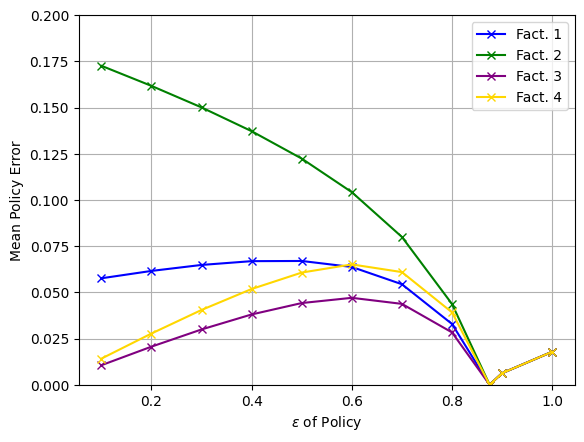

In [ ]:
plot_graphs(means, 'mean', 0.0, 0.2)

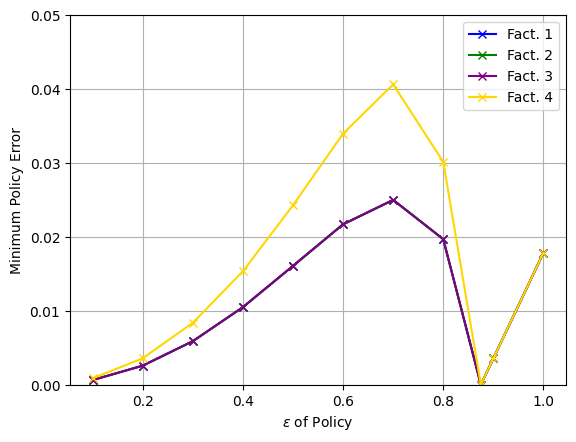

In [ ]:
plot_graphs(mins, 'min', 0.0, 0.05)

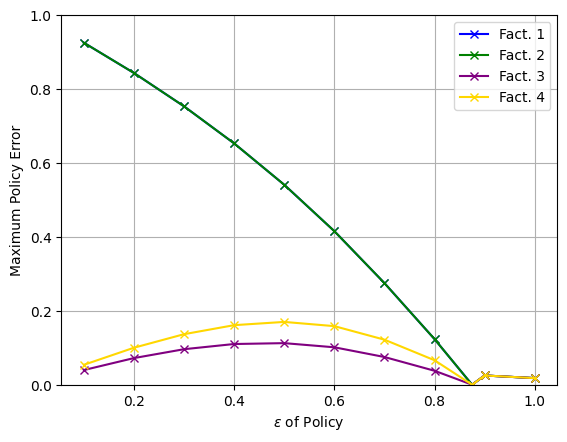

In [ ]:
plot_graphs(maxes, 'max', 0.0, 1.0)

## Max Error = Max Probability

In [5]:
memp =  {
    'Fact. 1': [1. - 0.2125, 1. - 0.2125, 1. - 0.2125, 1. - 0.2125, 1. - 0.2125, 1. - 0.2125, 1. - 0.2125, 1. - 0.7875, 1 - 0.9854166666666667, 1.0 - 0.0, 1.0 - 0.9854166666666667],
    'Fact. 2': [1. - 0.7319444444444444, 1. - 0.7319444444444444, 1. - 0.7319444444444444, 1. - 0.7319444444444444, 1. - 0.7319444444444444, 1. - 0.7319444444444444, 1. - 0.7319444444444444, 1. - 0.33194444444444443, 1 - 0.9854166666666667, 1.0 -0.0, 1.0 - 0.9854166666666667],
    'Fact. 3': [1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 1., 1 - 0.9854166666666667, 1.0 - 0.0, 1.0 - 0.9854166666666667],
    'Fact. 4': [1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 0.0, 1. - 1., 1 - 0.9854166666666667, 1.0 - 0.0, 1.0 - 0.9854166666666667]
}

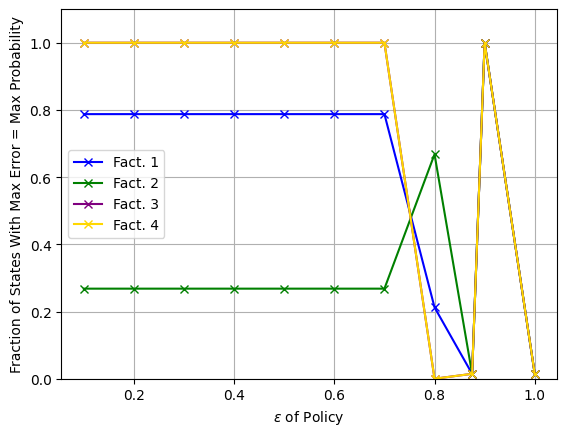

In [6]:
plot_graphs(memp, 'MeMp', 0.0, 1.1)